In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')
plt.style.use('fivethirtyeight')
import pandas as pd
import numpy as np
from collections import defaultdict

# 一些有用的工具函数

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon, size=len(v))

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

def z_clip(xs, b):
    return [min(x, b) for x in xs]

def g_clip(v):
    n = np.linalg.norm(v, ord=2)
    if n > 1:
        return v / n
    else:
        return v

使用Scikit-Learn实现逻辑回归

In [2]:
X = np.load('adult_processed_x.npy')
y = np.load('adult_processed_y.npy')

当要训练一个模型时，我们从所有可用的数据中选择一些数据来构造一组训练样本（如前所述），但我们也会留出一些数据作为测试样本。一旦训练完模型，我们肯定想要知道该模型在非训练样本上的表现如何。如果一个模型在未知的新样本上表现很好，我们称其泛化能力很好。一个泛化能力不足的模型，我们称其在训练数据上发生了过拟合。

我们使用测试样本来测试模型的泛化能力。由于我们事先已知测试样本的标签，我们可以让模型对每个测试样本进行分类，并比较预测标签和真实标签的结果，以测试模型的泛化能力。我们将把数据集切分为训练集和测试集。训练集包含80%的样本，而测试集包含其余20%的样本。

In [3]:
training_size = int(X.shape[0] * 0.8)

X_train = X[:training_size]
X_test = X[training_size:]

y_train = y[:training_size]
y_test = y[training_size:]

y_test.shape

(9044,)

构建一个二分类器的简单方法是使用逻辑回归（Logistic Regression）。scikit-learn库包含了一个实现逻辑回归的内置模块，名为LogisticRegression。通过调用此内置模块，很容易应用我们的数据构建二分类模型。

In [4]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(X_train[:1000],y_train[:1000])
model

LogisticRegression()

In [5]:
model.predict(X_test)

array([-1., -1., -1., ..., -1., -1., -1.])

In [6]:
np.sum(model.predict(X_test) == y_test)/X_test.shape[0]

0.8243034055727554

我们的模型对测试样本的标签预测准确率为82%。对该数据集来说，这是一个相当不错的预测准确率。

模型是什么？

有很多种不同类型的模型。这里我们要探讨的是线性模型（Linear Model）。

In [7]:
model.intercept_[0], model.coef_[0]

(-5.3461677503044145,
 array([ 3.76035057e-01, -2.55358856e-01, -3.21341426e-02,  3.74545737e-01,
        -6.85885223e-01,  3.91875239e-01, -1.69476241e-01, -7.41793527e-02,
        -5.76496538e-01,  3.94976503e-01, -3.41457312e-01, -6.24912317e-01,
        -6.05605602e-01, -4.56928100e-01, -5.19167009e-01, -1.05743009e-01,
         8.19586633e-01,  9.96762702e-01, -3.09342985e-01,  6.57277160e-01,
        -1.06436104e-01,  7.71287796e-01,  7.99791034e-02,  1.43803702e-01,
        -1.01006564e-01,  1.59416785e+00, -5.06233997e-02, -5.78477239e-01,
        -3.72601413e-01, -6.35661364e-01, -1.02810175e-01,  0.00000000e+00,
        -1.35478173e-01,  4.36864993e-01, -3.42554362e-01, -1.32819675e-01,
        -2.00200285e-01, -1.53919241e+00,  6.44831702e-02,  7.17836796e-01,
         3.80039408e-01,  4.25898498e-02,  8.81653483e-01, -7.08110462e-02,
         6.10385977e-02,  8.94590966e-02,  6.93679716e-01, -1.30382712e+00,
        -6.55878656e-01,  1.11512993e+00,  3.78012650e-01, -4.2823

In [8]:
# 预测：以模型（theta）单一样本（xi）为输入，返回预测标签
def predict(xi, theta, bias=0):
    label = np.sign(xi @ theta + bias)
    return label

np.sum(predict(X_test, model.coef_[0], model.intercept_[0]) == y_test)/X_test.shape[0]

0.8243034055727554

使用梯度下降训练模型（Gradient Descent）

In [9]:
# 损失函数用于衡量我们的模型有多好。训练目标是最小化损失值。
# 这是对率损失函数。
def loss(theta, xi, yi):
    exponent = - yi * (xi.dot(theta))
    return np.log(1 + np.exp(exponent))

In [10]:
theta = np.zeros(X_train.shape[1])
loss(theta, X_train[0], y_train[0])

0.6931471805599453

一般来说，通过简单地计算所有训练样本的平均损失值，我们就可以测量出模型在整个训练集上有多好。当模型的权重全为0时，所有样本全部预测错误，整个训练集的平均损失值刚好等于我们前面计算得到的单个样本损失值。

In [11]:

np.mean([loss(theta, x_i, y_i) for x_i, y_i in zip(X_train, y_train)])

0.6931471805599453

In [12]:
# 这是对率损失函数的梯度
# 梯度是一个表示各个方向损失变化率的向量
def gradient(theta, xi, yi):
    exponent = yi * (xi.dot(theta))
    return - (yi*xi) / (1+np.exp(exponent))

单步梯度下降

In [13]:
# 如果我们想把我们向梯度的反方向移动一步（即减去梯度值），
# 我们应该可以让theta向损失值*变小）的方向移动
# 这就是单步梯度下降。我们在每一步都要尝试*降低*梯度
# 在这个例子中，我们只计算了训练集中（第）一个样本的梯度
theta = theta - gradient(theta, X_train[0], y_train[0])
theta

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.5       ,
        0.        ,  0.        ,  0.        , -0.5       ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.5       ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.5       ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.5       ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.5       ,
        0.        , -0.5       ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [14]:
y_train[0], predict(theta, X_train[0])

(-1.0, -1.0)

In [15]:
def accuracy(theta):
    return np.sum(predict(X_test, theta) == y_test)/X_test.shape[0]

accuracy(theta)

0.7585139318885449

梯度下降算法

In [16]:
def avg_grad(theta, X, y):
    grads = [gradient(theta, xi, yi) for xi, yi in zip(X, y)]
    return np.mean(grads, axis=0)

avg_grad(theta, X_train, y_train)

array([-8.03202480e-03, -1.09365062e-02, -5.86649848e-02, -1.70297784e-02,
       -1.85949049e-02, -5.32762100e-03,  3.15432083e-05,  2.24692568e-03,
        1.80942171e-03,  1.10891317e-03,  7.17940863e-04,  1.22012681e-03,
        1.09385854e-03,  1.42352970e-03, -4.29266203e-03, -5.73114012e-03,
       -4.96409990e-02, -7.90844879e-03, -1.08970068e-02, -2.50609905e-02,
        3.27410319e-04, -1.20102580e-02, -1.29608985e-02,  1.15182321e-02,
       -2.26895536e-04, -1.83255483e-01,  1.34642262e-03,  4.47703452e-02,
        4.31895523e-03,  2.97414610e-03,  6.16295082e-03, -4.88903955e-05,
       -2.13933205e-02, -4.86969833e-02, -8.62802483e-04,  3.11463168e-03,
        1.23013848e-03,  1.54486498e-02,  1.21336873e-03, -4.38864985e-02,
       -4.34689131e-03, -1.64743409e-02, -4.53583200e-03, -5.47845717e-03,
       -1.67472715e-01,  1.93015718e-02,  4.73608091e-03,  2.44149704e-02,
        1.61917788e-02, -1.57259641e-02,  6.59058497e-04, -1.58429762e-03,
        9.21938268e-03,  

对于第二个改进点，我们来定义一个可以多次执行梯度下降的迭代算法。

In [17]:
def gradient_descent(iterations):
    # 我们用"猜测"的一个模型参数（权重全为0的模型）作为起始点
    theta = np.zeros(X_train.shape[1])

    # 应用训练集迭代执行梯度下降步骤
    for i in range(iterations):
        theta = theta - avg_grad(theta, X_train, y_train)

    return theta

In [18]:
theta = gradient_descent(10)
accuracy(theta)

0.7787483414418399

还有一个有趣的现象值得我们注意：损失函数的输出值确实会随着每轮梯度下降的迭代而下降。因此，随着执行轮数的增加，我们的模型的确在逐渐接近最小损失值。另外要注意的是，如果训练集和测试集的损失值非常接近，意味着我们的模型没有过拟合训练数据。

In [19]:
def gradient_descent_log(iterations):
    theta = np.zeros(X_train.shape[1])

    for i in range(iterations):
        theta = theta - avg_grad(theta, X_train, y_train)
        print(f'训练集损失值: {np.mean(loss(theta, X_train, y_train))}')
        print(f'测试集损失值: {np.mean(loss(theta, X_test, y_test))}\n')

    return theta

gradient_descent_log(5);

训练集损失值: 0.549109439168421
测试集损失值: 0.5415350837580458

训练集损失值: 0.5224689105514977
测试集损失值: 0.5162665121068426

训练集损失值: 0.5028090736020403
测试集损失值: 0.49753785424732383

训练集损失值: 0.4878874803989895
测试集损失值: 0.48335633696635527

训练集损失值: 0.47628573924997925
测试集损失值: 0.4723742456095848



差分隐私梯度下降

算法执行过程中唯一使用了训练数据的部分是梯度计算步骤。使该算法满足差分隐私的一种方法是，在每轮模型更新前在梯度上增加噪声。由于我们直接在梯度上增加噪声，因此该方法通常被称为噪声梯度下降（Noisy Gradient Descent）。

In [20]:
def noisy_gradient_descent(iterations, epsilon, delta):
    theta = np.zeros(X_train.shape[1])
    sensitivity = '???'

    for i in range(iterations):
        grad = avg_grad(theta, X_train, y_train)
        noisy_grad = gaussian_mech_vec(grad, sensitivity, epsilon, delta)
        theta = theta - noisy_grad

    return theta

这里就差一块拼图了：梯度函数的敏感度是多少？这是使算法满足差分隐私的关键所在。

这里我们主要面临两个挑战。第一，梯度是均值问询的结果，即梯度是每个样本梯度的均值。我们之前已经提到，最好将均值问询拆分为一个求和问询和一个计数问询。做到这一点并不难，我们可以不直接计算梯度均值，而是计算每个样本梯度噪声和，再除以噪声计数值。第二，我们需要限制每个样本梯度的敏感度。有两种基础方法可以做到这一点。我们可以（如之前讲解的其他问询那样）分析梯度函数，确定其在最差情况下的全局敏感度。我们也可以（如"采样-聚合"框架那样）裁剪梯度函数的输出值，从而强制限定敏感度上界。

我们先介绍第二种方法。第二种方法从概念上看更简单，在实际应用中的普适性更好。此方法一般被称为梯度裁剪（Gradient Clipping）。

梯度裁剪

In [21]:
def L2_clip(v, b):
    norm = np.linalg.norm(v, ord=2)
    
    if norm > b:
        return b * (v / norm)
    else:
        return v

In [22]:
def gradient_sum(theta, X, y, b):
    gradients = [L2_clip(gradient(theta, x_i, y_i), b) for x_i, y_i in zip(X,y)]
        
    # 求和问询
    # （经过裁剪后的）L2敏感度为b
    return np.sum(gradients, axis=0)

In [23]:
def noisy_gradient_descent(iterations, epsilon, delta):
    theta = np.zeros(X_train.shape[1])
    sensitivity = 5.0
    
    noisy_count = laplace_mech(X_train.shape[0], 1, epsilon)

    for i in range(iterations):
        grad_sum        = gradient_sum(theta, X_train, y_train, sensitivity)
        noisy_grad_sum  = gaussian_mech_vec(grad_sum, sensitivity, epsilon, delta)
        noisy_avg_grad  = noisy_grad_sum / noisy_count
        theta           = theta - noisy_avg_grad

    return theta

In [24]:
theta = noisy_gradient_descent(10, 0.1, 1e-5)
accuracy(theta)

0.7852720035382574

梯度的敏感度

In [25]:
def gradient_sum(theta, X, y, b):
    gradients = [gradient(theta, x_i, y_i) for x_i, y_i in zip(X,y)]

    # 求和问询
    # （经过裁剪后的）L2敏感度为b
    return np.sum(gradients, axis=0)

In [26]:
def noisy_gradient_descent(iterations, epsilon, delta):
    theta = np.zeros(X_train.shape[1])
    sensitivity = 5.0
    
    noisy_count = laplace_mech(X_train.shape[0], 1, epsilon)
    clipped_X = [L2_clip(x_i, sensitivity) for x_i in X_train]

    for i in range(iterations):
        grad_sum        = gradient_sum(theta, clipped_X, y_train, sensitivity)
        noisy_grad_sum  = gaussian_mech_vec(grad_sum, sensitivity, epsilon, delta)
        noisy_avg_grad  = noisy_grad_sum / noisy_count
        theta           = theta - noisy_avg_grad

    return theta

In [27]:
theta = noisy_gradient_descent(10, 0.1, 1e-5)
accuracy(theta)

0.7785272003538257

噪声对训练的影响

In [28]:
delta = 1e-5

epsilons = [0.001, 0.003, 0.005, 0.008, 0.01, 0.03, 0.05, 0.08, 0.1]
thetas   = [noisy_gradient_descent(10, epsilon, delta) for epsilon in epsilons]
accs     = [accuracy(theta) for theta in thetas]

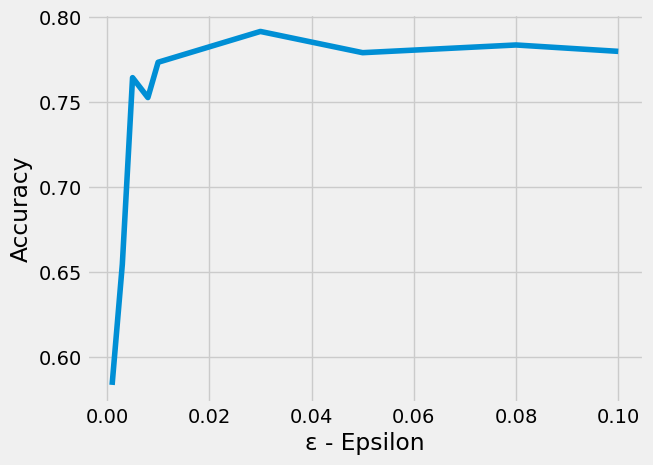

In [31]:
plt.xlabel('ε - Epsilon')
plt.ylabel('Accuracy')
plt.plot(epsilons, accs);